# Introduction
This project is a demonstration of:
- pretrained large language model (LLM) application to perform sentiment analysis from
a financial domain
- several skills of model improvement and manipulation

Dataset: [HuggingFace financial_phrasebank](https://huggingface.co/datasets/financial_phrasebank)
- a collection of hand-annotated sentences with sentiment classified into Negative, Neutral, Positive
- Subdataset: sentences_50agree, sentences_66agree, sentences_75agree, sentences_allagree (The hand-annotated datasets have 50%/66%/75%/100% agreement rate by 5-8 annotators); this project will mainly use the sentences_allagree subdataset.

Notes: LLM traing process will consume a large amount of computing resources and memory. I recommend to run this program using Google Colab Pro, or other high-performance computing resources.

# Table of Contents
1. Pre-Training Model + Supervised Fine-Tuning
2. Have a Look at Data
3. Create Train/Validation/Test Sets
4. Define Perfomance Measure
5. Exploratory Data Analysis
6. Prepare the Data
7. Pre-Trained Model + Supervised Fine-Tuning
  - Fine-Tune Only Classifier Head
  - Fine-Tune All Weights
8. Error Analysis
9. Additional: Create and Fit Model With TensorFlow Dataset(TFDS)
10. Additional: Create Customnized Classification Head
11. Additional: In-Context Learning

In [1]:
%%capture
!pip install imbalanced-learn -q
!pip install datasets -q
!pip install transformers -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/your_path_to_directory')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
print("Running TensorFlow version ",tf.__version__)

import model_helper
hp = model_helper.Helper()
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDistilBertModel

Running TensorFlow version  2.13.0


# Get the Data
- Get "sentences_allagree" subset from the Hugging Face "financial_phrasebank" dataset

In [4]:
%%capture
dataset = load_dataset('financial_phrasebank','sentences_allagree', split="train")

# Have a Look
In the following cells, we know the dataset includes only two types of information.

- sentence
- label: [0, 1, 2], which represents [negative, neutral, positive] separately

In [5]:
dataset[:5]

{'sentence': ['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .',
  'Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .',
  'Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .'],
 'label': [1, 2, 2, 2, 2]}

# Create Test Set
Sometimes the dataset is sorted based on a certain condition. For example, sorted by the length of a sentence or the time when the sentence is created. To avoid any bias during model training, I shuffle the data first, and then split them into the train, validation, and test subset.

In [6]:
sentences, labels = shuffle(dataset['sentence'], dataset['label'], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [7]:
print("Data size by (Train, Validation, Test): ", (len(X_train), len(X_val), len(X_test)))

Data size by (Train, Validation, Test):  (1539, 385, 340)


# Define Performance Measure

Sentiment analysis is a classification problem. I will monitor two metrics during the model training.

1. loss: categorical crossentropy
2. accuracy: (TP + TN) / (TP + TN + FP + FN)

Also, I will evaluate each model based on the following scores on the test data.

1. precision: TP / (TP + FP)
2. recall: TP / (TP + FN)
3. f1-score: 2 * (precision * recall) / (precision + recall)
4. confusion matrix

where:

TP (True Positive): the number of correctly predicted positive instances

TN (True Negative): the number of correctly predicted negative instances

FP (False Positive): the number of incorrectly predicted positive instances

FN (False Negative): the number of incorrectly predicted negative instances

# Exploratory Data Analysis
Here I focus on the train data for analysis to prevent cheating. To get statistical information on the dataset, I tokenize sentences first.

In [8]:
# vocab_size = 120
# embedding_dim = 16
# trunc_type = 'post'
# oov_tok = '<OOV>'
# padding_type = 'post'

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

X_train_token = tokenizer.texts_to_sequences(X_train)
X_val_token = tokenizer.texts_to_sequences(X_val)
X_test_token = tokenizer.texts_to_sequences(X_test)

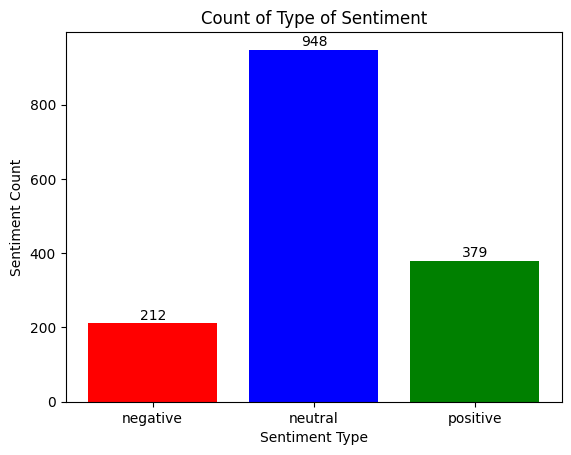

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
count_label = dict(zip(unique, counts))

plt.plot(figsize=(10,3))
plt.bar(count_label.keys(), count_label.values(), color=['red','blue','green'])
plt.xticks(list(count_label.keys()), ['negative','neutral','positive'] , rotation=0)
for index, value in enumerate(count_label.values()):
    plt.text(index-0.08, value+10, str(value))
plt.xlabel('Sentiment Type')
plt.ylabel('Sentiment Count')
plt.title('Count of Type of Sentiment')
plt.show()

We can conclude that it is an imbalanced dataset. Most of the sentences are marked as "neutral", sentences marked as "positive" or "negative" are not that many. Thus, I will handle this issue later.

In [10]:
X_train_temp = np.array(X_train_token, dtype=list)

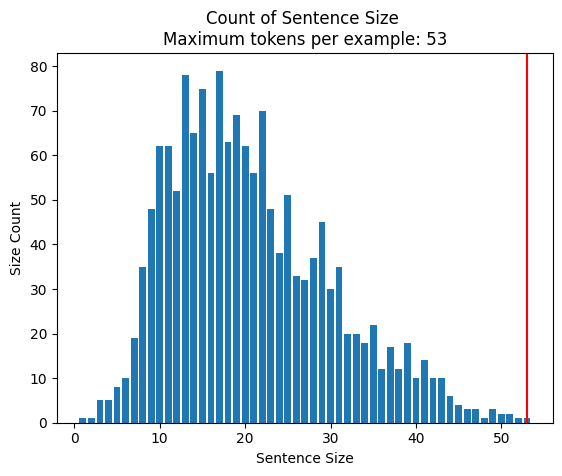

In [11]:
sentence_size = []
for s in X_train_temp:
    sentence_size.append(len(s))
size, counts = np.unique(sentence_size, return_counts=True)

plt.plot(figsize=(10,3))
plt.bar(size, counts)
plt.axvline(x = max(size), color = 'r')
plt.xlabel('Sentence Size')
plt.ylabel('Size Count')
plt.title(f'Count of Sentence Size \nMaximum tokens per example: {max(size)}')
plt.show()

According to the above graph, we learn the distribution of the sentence length. The majority of sentence size is 10-20 words. The max length is 53, which is not too long, and we don't have to worry much about the max length and truncation issue in this case.

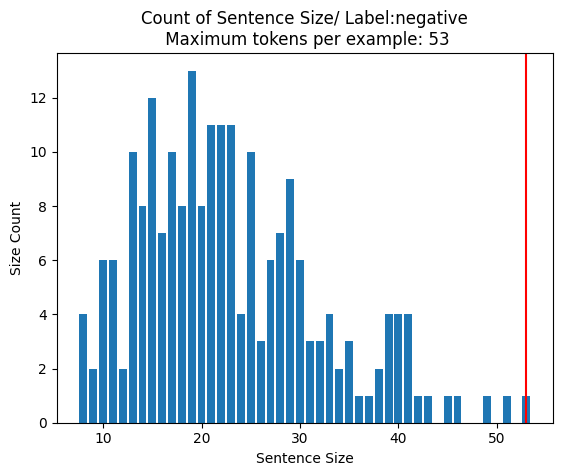

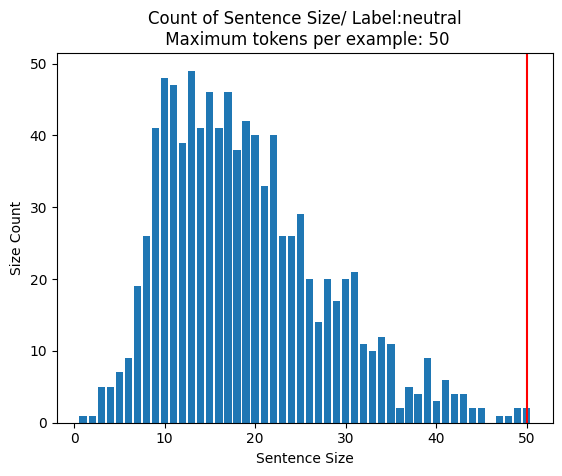

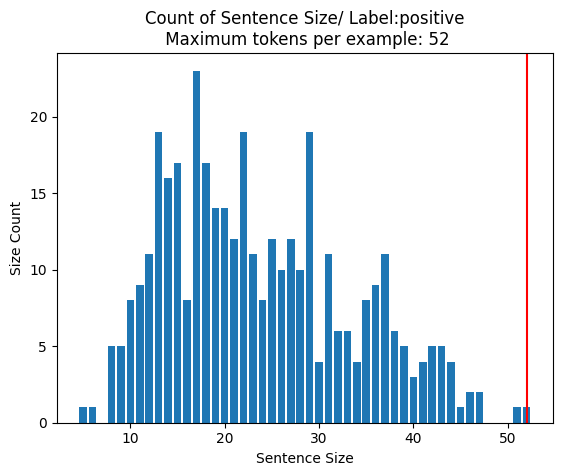

In [12]:
for i, lb in enumerate(['negative','neutral','positive']):
    sentence_size = []
    for s in X_train_temp[np.array(y_train)==i]:
        sentence_size.append(len(s))
    size, counts = np.unique(sentence_size, return_counts=True)

    plt.plot(figsize=(10,3))
    plt.bar(size, counts)
    plt.axvline(x = max(size), color = 'r')
    plt.xlabel('Sentence Size')
    plt.ylabel('Size Count')
    plt.title(f'Count of Sentence Size/ Label:{lb}\n Maximum tokens per example: {max(size)}')
    plt.show()

Separating the train data by their labels, we can observe the distribution of the sentence length of each subset. For each subset, most of the sentence length is also 10-20 words and the max length is around 50-53. We can tell the data set is not significantly biased.

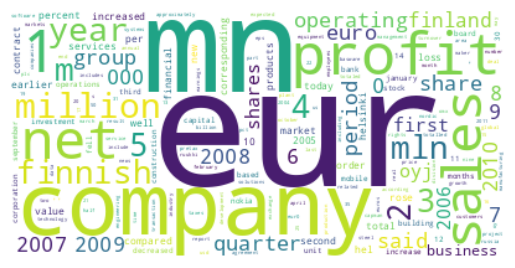

In [13]:
txt = []
for s in X_train_temp:
    txt = txt + s

unique, counts = np.unique(txt, return_counts=True)
count_label = dict(zip(unique, counts))

d = dict((k, count_label.get(v)) for (k, v) in word_index.items() if count_label.get(v) is not None)
sorted_d = sorted(d.items(), key=lambda x: x[1])[::-1]
stop_words = ["will", "'s"] + list(STOPWORDS)
final_d = dict(((k, v) for k, v in dict(sorted_d).items() if k not in stop_words))

wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(frequencies=final_d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

I remove some common words that are unhelpful for sentiment analysis from the word cloud graph, such as "a", "the", and "will". We learn that "eur", "company", "mn" (million) show most frequently in the dataset, which is common as it's a financial-related dataset.

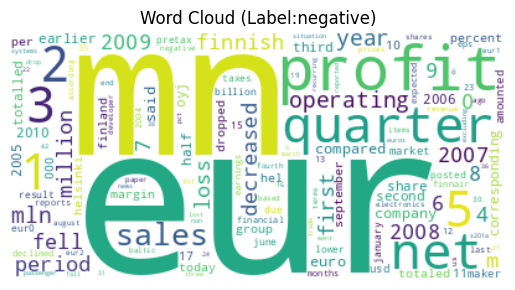

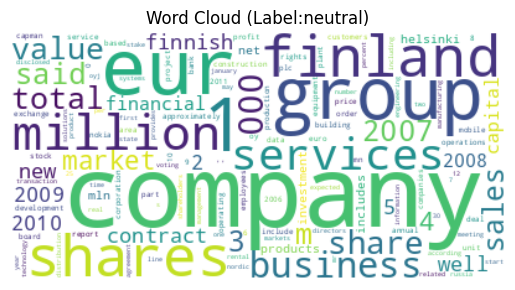

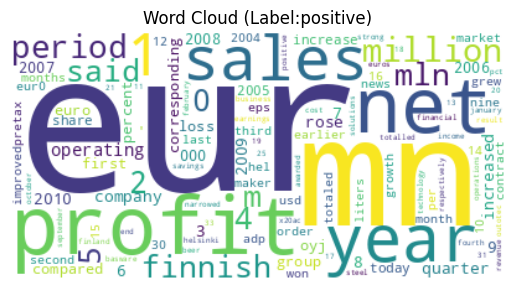

In [14]:
for i, lb in enumerate(['negative','neutral','positive']):
    txt = []
    for s in X_train_temp[np.array(y_train)==i]:
        txt = txt + s

    unique, counts = np.unique(txt, return_counts=True)
    count_label = dict(zip(unique, counts))

    d = dict((k, count_label.get(v)) for (k, v) in word_index.items() if count_label.get(v) is not None)
    sorted_d = sorted(d.items(), key=lambda x: x[1])[::-1]
    stop_words = ["will", "'s"] + list(STOPWORDS)
    final_d = dict(((k, v) for k, v in dict(sorted_d).items() if k not in stop_words))

    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(frequencies=final_d)
    plt.figure()
    plt.title(f'Word Cloud (Label:{lb})')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Separating the training data by their labels, we can find that the sub-dataset marked as "positive" or "negative" often includes the "profit" and "sales" words. In practice, we can include more sentences about these topics if the model performance is not good due to the imbalanced data.

# Prepare the Data
- Addressing imbalanced data: to oversample the positive- and negative-label data randomly to make the data number of each label the same.
    - Note: I don't use Sklearn's SMOTE and CountVectorizer because we cannot ensure that the generated sentence data is readable and reasonable. Therefore, I choose to apply RandomOverSampler to duplicate some samples in the dataset, converting the imbalanced data into balanced data.

- Pre-Trained Model: "distilbert-base-uncased" model as the pre-trained model.
    - As each pre-trained model may use a different way to tokenize the sentence, it's essential to collect its tokenizer for data preparation.

In [15]:
from imblearn.over_sampling import RandomOverSampler
X_train_temp = [[s] for s in X_train]
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_temp, y_train)
X_train_res = [s[0] for s in X_train_res]

In [16]:
for i, cl in enumerate(['negative','neutral','positive'] ):
    print(cl, ' Sample Counts: ', np.sum(np.array(y_train_res)==i))

negative  Sample Counts:  948
neutral  Sample Counts:  948
positive  Sample Counts:  948


In [17]:
# Load the tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

X_train_token = tokenizer(X_train_res, padding="max_length", return_tensors="np", max_length = 150)
X_val_token = tokenizer(X_val, padding="max_length", return_tensors="np", max_length = 150)
X_test_token = tokenizer(X_test, padding="max_length", return_tensors="np", max_length = 150)

# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
X_train_token = dict(X_train_token)
X_val_token = dict(X_val_token)
X_test_token = dict(X_test_token)

In [18]:
y_train_res = np.array(y_train_res)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Pre-Trained Model + Supervised Fine-Tuning
- Objective: to obtain a pre-trained model with a classification head, which is automatically provided by HuggingFace API, and perform Sentiment Analysis on sentences
- Method: to use the Unsupervised Pre-Training + Supervised Fine-Tuning paradigm
    - Pre-Trained Language Model from the HuggingFace platform
    - Fine-Tune the model based on the dataset

## Fine-Tune Only Classifier Head
As we can see, the Hugging Face API adds 3 layers to the pre-trained model for classification. Thus, I will freeze the pre-trained model, and unfreeze the 3 layers of the head for model training.

In [19]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model training time: 29.49820041656494 seconds


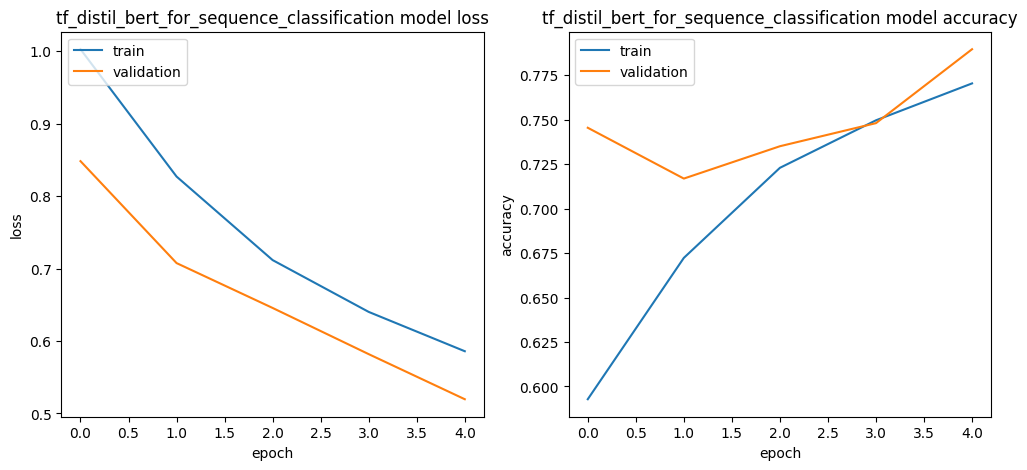

In [20]:
model.trainable = True
model.layers[0].trainable = False

start_time = time.time()
model, score = hp.TrainModel(model, (X_train_token, y_train_res), (X_val_token, y_val), (X_test_token, y_test))
print("Model training time: %s seconds" % (time.time() - start_time))

In [21]:
fine_method = 'Head_fine_tune'
sub_dataset = 'All_agree'
train_size = len(y_train)
ds_bool = '' # Y/N using TensorFlow Dataset

hp.summary_table = hp.RecordToSummary(hp.summary_table, model.name, fine_method, sub_dataset, train_size, ds_bool, score)

Model          tf_distil_bert_for_sequence_classification
Fine Method                                Head_fine_tune
Sub-Dataset                                     All_agree
Train Size                                           1539
tf Dataset                                               
train loss                                       0.545368
train acc                                        0.793952
val loss                                         0.519637
val acc                                           0.78961
test loss                                        0.467155
test acc                                         0.847059
Name: 0, dtype: object

              precision    recall  f1-score   support

           0      0.609     0.718     0.659        39
           1      0.934     0.934     0.934       213
           2      0.753     0.693     0.722        88

    accuracy                          0.847       340
   macro avg      0.765     0.782     0.772       340
weighted avg      0.850     0.847     0.848       340



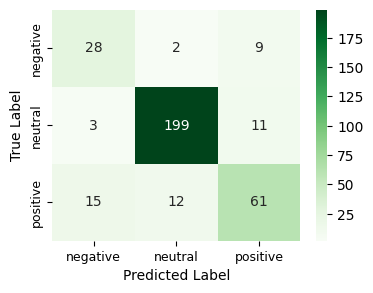

In [22]:
display(hp.summary_table.iloc[-1,:])
hp.EvaluateModel(model, X_test_token, y_test)

According to the above performance summary, the average accuracy score, precision, recall, and f1-score look not bad, overall higher than 0.7. However, this model tends to classify positive sentences incorrectly into other sentiments, and there are relatively more false-positive cases.

## Fine-Tune All Weights

Model training time: 80.46352076530457 seconds


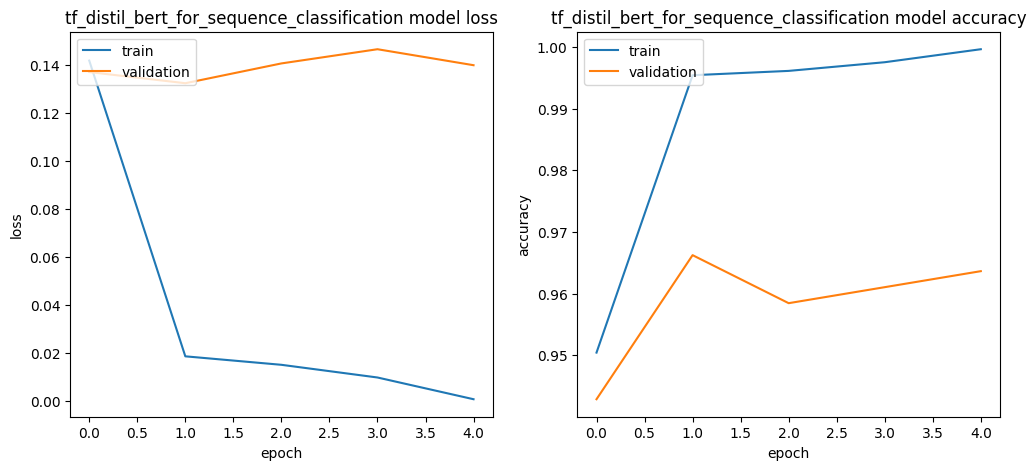

In [23]:
model.trainable = True

start_time = time.time()
model, score = hp.TrainModel(model, (X_train_token, y_train_res), (X_val_token, y_val), (X_test_token, y_test))
print("Model training time: %s seconds" % (time.time() - start_time))

In [24]:
fine_method = 'All_fine_tune'
sub_dataset = 'All_agree'
train_size = len(y_train)
ds_bool = ''

hp.summary_table = hp.RecordToSummary(hp.summary_table,  model.name, fine_method, sub_dataset, train_size, ds_bool, score)

Model          tf_distil_bert_for_sequence_classification
Fine Method                                 All_fine_tune
Sub-Dataset                                     All_agree
Train Size                                           1539
tf Dataset                                               
train loss                                       0.000165
train acc                                             1.0
val loss                                          0.14007
val acc                                          0.963636
test loss                                        0.186642
test acc                                         0.961765
Name: 1, dtype: object

              precision    recall  f1-score   support

           0      0.844     0.974     0.905        39
           1      0.986     0.986     0.986       213
           2      0.963     0.898     0.929        88

    accuracy                          0.962       340
   macro avg      0.931     0.953     0.940       340
weighted avg      0.964     0.962     0.962       340



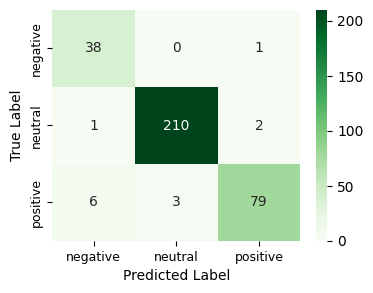

In [25]:
display(hp.summary_table.iloc[-1,:])
hp.EvaluateModel(model, X_test_token, y_test)

We can tell that fine-tining all the weights get much better results! The accuracy, precision, recall, f1-score on the test data are all above 0.9, and no more than 10 sentences in each class are misclassified.

# Error Analysis
Consider:
- Is one class harder to correctly classify than others?
- Is there some systematic pattern of errors?

In [26]:
y_test_pred = model.predict(X_test_token)

11/11 [==============================] - 0s 23ms/step


In [27]:
condition = (np.array(y_test) != (np.argmax(y_test_pred[0], axis=1)))
error_sentence = np.array(X_test)[condition]
error_true_label = np.array(y_test)[condition]
error_pred_label = np.argmax(y_test_pred[0], axis=1)[condition]
error_analysis = pd.DataFrame([error_sentence, error_true_label, error_pred_label]).T
error_analysis.columns=['Sentence', 'True Label', 'Predicted Label']

In [28]:
pd.set_option('display.max_colwidth', None)

display(error_analysis[error_analysis['True Label']==0])
display(error_analysis[error_analysis['True Label']==1])
display(error_analysis[error_analysis['True Label']==2])

,Sentence,True Label,Predicted Label
0,Operating profit excluding non-recurring items was EUR 7.8 million compared to EUR 11.2 million .,0,2


,Sentence,True Label,Predicted Label
1,"The sale of Savcor FACE to Cencorp will result in a profit or loss which can not yet be determined , owing to factors including the valuation of the consideration shares to be received and prevailing exchange rates .",1,0
3,Nordea was the cheapest also for a couple in their 30s with debt .,1,2
6,"New Delhi , July 17 -- Sahlberg Teppo , Kallio Timo and Mustonen Tuomas of M Real OYJ , Espoo , Finland have developed novel markings and methods of producing the same .",1,2


,Sentence,True Label,Predicted Label
2,"Finnish steel maker Rautaruukki Oyj ( HEL : RTRKS ) , or Ruukki , said today its net loss contracted to EUR 49 million ( USD 68.2 m ) for the first nine months of 2010 from EUR 229 million for the same period a year ago .",2,0
4,The company reports a loss for the period of EUR 0.4 mn compared to a loss of EUR 1.9 mn in the corresponding period in 2005 .,2,0
5,The loss for the third quarter of 2007 was EUR 0.3 mn smaller than the loss of the second quarter of 2007 .,2,0
7,"This location makes the mall a convenient place to shop for consumers from three large residential areas nearby : Jaroszowka , Wysockiego and Zgody .",2,1
8,"Metsaliitto , however , narrowed its net loss for the second quarter of 2007 to 5.0 mln euro $ 6.9 mln from 61 mln euro $ 83.7 mln a year ago .",2,0
9,The company also said that in Poland a profitability program has been launched at the Oborniki steel frame and sandwich panel plant .,2,1
10,"Pre-tax loss totaled EUR 0.3 mn , compared to a loss of EUR 2.2 mn in the first quarter of 2005 .",2,0
11,It therefore seems that Finnish shipping company Viking Line will get the subsidy it needs to order its new LNG-fuelled vessel .,2,1
12,"However , the broker gave an `` outperform '' recommendation on the stock .",2,0


From the above table, we can find more positive-sentiment sentences are misclassified, and the possible reason is as follows:
- positive sentences are misclassified as negative because
    - they include some negative words, but the model didn't know another negative word gives an offset effect.
    - they include some negative words, but the model didn't know the level of negative attitude acctually decreases "compared to that before."

- positive sentences are misclassified as neutral because
    - some positive terms or phrases weren't identified as "positive", e.g. profitability, convenient, "get the subsidy it needs".

To improve the model, we can increase into training samples with similar sentence structure or specific terms.

# Additional: Create and Fit Model With TensorFlow Dataset (TFDS)

- Objective: to increase memory efficiency for data loading and preprocessing
- Method: to apply TensorFlow Dataset to data preprocessing

TensorFlow Dataset can efficiently load and preprocess data in parallel and in smaller chunks (batches) to minimize memory consumption, which is valuable for working with large datasets. It can also automatically prefetch and cache data, which reduces data loading times and keeps the GPU busy with computation rather than waiting for data.

- Tokenize the sentence and create a TFDS
- Have a look at two samples to confirm it works well

In [29]:
sentences_token = tokenizer(dataset['sentence'], padding=True, return_tensors="np")
tf_ds = tf.data.Dataset.from_tensor_slices((dict(sentences_token), dataset['label']))
for sample in tf_ds.take(2):
    print(sample)

({'input_ids': <tf.Tensor: shape=(150,), dtype=int64, numpy=
array([  101,  2429,  2000, 12604,  1010,  1996,  2194,  2038,  2053,
        3488,  2000,  2693,  2035,  2537,  2000,  3607,  1010,  2348,
        2008,  2003,  2073,  1996,  2194,  2003,  3652,  1012,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  

- Creat Train/Validation/Test Data

In [30]:
tf_ds = tf_ds.shuffle(len(tf_ds), reshuffle_each_iteration=False, seed=42)

In [31]:
train_size = int(0.85 * len(dataset))
X_train_tfds, test_tfds = tf_ds.take(train_size), tf_ds.skip(train_size).prefetch(tf.data.AUTOTUNE)

train_size = int(0.80 * len(X_train_tfds))
train_tfds, val_tfds = X_train_tfds.take(train_size), X_train_tfds.skip(train_size).prefetch(tf.data.AUTOTUNE)

print("Data size by (Train, Validation, Test): ", (len(train_tfds), len(val_tfds), len(test_tfds)))

Data size by (Train, Validation, Test):  (1539, 385, 340)


- Address imbalanced data by oversampling

In [32]:
train_label_size = [0, 0, 0] # [negtive, neutral, positive]
train_labeled_dataset = []
for i in range(3):
    train_labeled_dataset.append(train_tfds.filter(lambda x, y: y == i))
    train_label_size[i] = train_labeled_dataset[-1].reduce(0, lambda x, _: x + 1).numpy()
print("Train data size by lables (0, 1, 2): ", (train_label_size[0], train_label_size[1], train_label_size[2]))

Train data size by lables (0, 1, 2):  (199, 948, 392)


In [33]:
train_labeled_dataset[2] = train_labeled_dataset[2].repeat(train_label_size[1] // train_label_size[2])
train_labeled_dataset[0] = train_labeled_dataset[0].repeat(train_label_size[1] // train_label_size[0])
for i in range(3):
    train_label_size[i] = train_labeled_dataset[i].reduce(0, lambda x, _: x + 1).numpy()
print("Train data size by lables (0, 1, 2): ", (train_label_size[0], train_label_size[1], train_label_size[2]))

Train data size by lables (0, 1, 2):  (796, 948, 784)


In [34]:
balanced_train_tfds = train_labeled_dataset[0].concatenate(train_labeled_dataset[1]).concatenate(train_labeled_dataset[2])
train_tfds_size = balanced_train_tfds.reduce(0, lambda x, _: x + 1).numpy()

balanced_train_tfds = balanced_train_tfds.shuffle(train_tfds_size, seed=42).prefetch(tf.data.AUTOTUNE)
val_tfds = val_tfds.shuffle(len(val_tfds), seed=42).prefetch(tf.data.AUTOTUNE)

- Fine-tuning all weights with TFDS

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model training time: 80.50522780418396 seconds


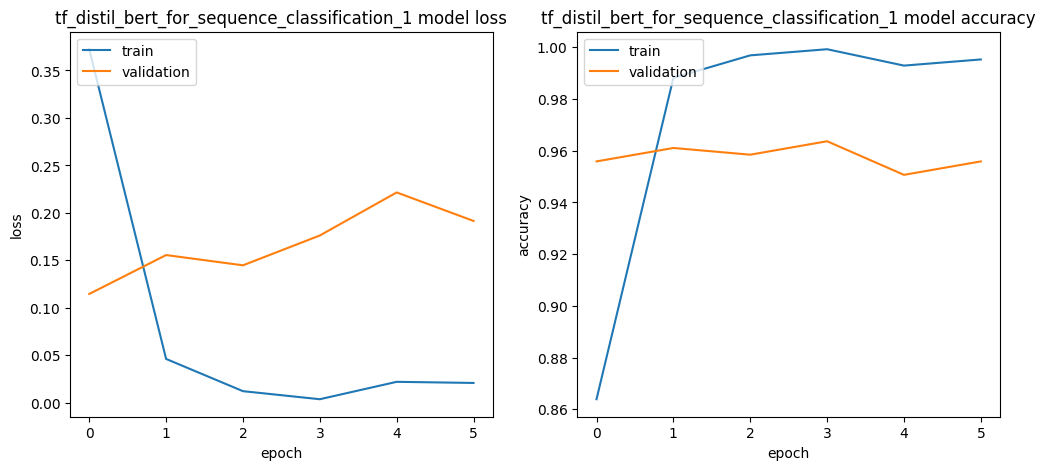

In [35]:
model_name = 'distilbert-base-uncased'
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

start_time = time.time()
model, score = hp.TrainModelTFDS(model, balanced_train_tfds, val_tfds, test_tfds)
print("Model training time: %s seconds" % (time.time() - start_time))

In [36]:
fine_method = 'All_fine_tune'
sub_dataset = 'All_agree'
train_size = train_tfds_size
ds_bool = 'tfds'

hp.summary_table = hp.RecordToSummary(hp.summary_table, model_name, fine_method, sub_dataset, train_size, ds_bool, score)

Model          distilbert-base-uncased
Fine Method              All_fine_tune
Sub-Dataset                  All_agree
Train Size                        2528
tf Dataset                        tfds
train loss                    0.046883
train acc                      0.99288
val loss                      0.114655
val acc                       0.955844
test loss                     0.132473
test acc                      0.952941
Name: 2, dtype: object

              precision    recall  f1-score   support

           0      0.902     0.868     0.885        53
           1      0.981     0.985     0.983       205
           2      0.916     0.927     0.921        82

    accuracy                          0.953       340
   macro avg      0.933     0.927     0.930       340
weighted avg      0.953     0.953     0.953       340



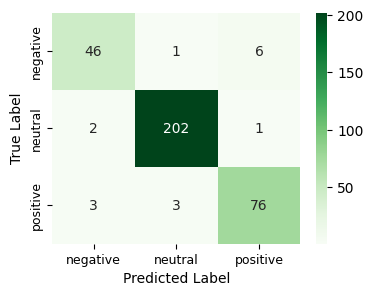

In [37]:
display(hp.summary_table.iloc[-1,:])
hp.EvaluateModel(model, test_tfds, y_test)

The result is also pretty good and similar to that in the Fine-tuing all weights with non-TFDS data. The accuracy, precision, recall, and f1-score on the test data are all above 0.9. It meets what we expect as the model, dataset, and manipulation are almost the same as those in the basic part except that the data type used is TFDS, not the built-in Python data type.

# Additional: Create Customized Classification Head
- Objective: to create a customized classification head to a head-less model from HugginFace, rather than using a classification head automatically provided with the HuggingFace model
    - It's also a practice of creating a customized classification model.

Here I choose the same model as that in the basic part, "distilbert-base-uncased", but without the classification head added by Hugging face API. As we can see from the model summary, there is only the pre-trained model and no extra layers for classification.

In [38]:
model_name = 'distilbert-base-uncased'
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
transformer_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The following is my customized model, and its structure is

- Layer 1: the pre-trained model
- Layer 2: a pre-classification dense layer
- Layer 3: GlobalAveragePooling1D layer to reduce the data dimension
- Layer 4: a classification layer for 3 classes

In [39]:
from transformers import TFAutoModelForSequenceClassification

class MyCustomModel(tf.keras.Model):

    def __init__(self, num_classes=3):
        super(MyCustomModel, self).__init__(name="MyCustomModel")
        self.num_classes = num_classes

        self.transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dense = tf.keras.layers.Dense(256,activation='sigmoid')
        self.pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.classifier = tf.keras.layers.Dense(num_classes)

    def call(self, inputs):
        transformer = self.transformer_model(inputs)
        last_hidden_state = transformer[0]
        sequence_outputs = self.dense(last_hidden_state)
        x = self.pooling(sequence_outputs)
        return self.classifier(x)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model training time: 56.715646266937256 seconds


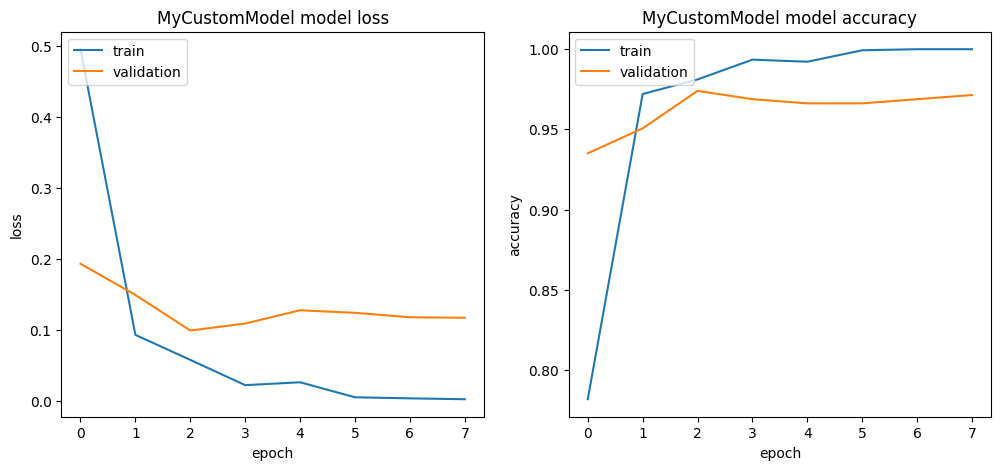

In [40]:
model = MyCustomModel()

start_time = time.time()
model, score = hp.TrainModelTFDS(model, train_tfds, val_tfds, test_tfds)
print("Model training time: %s seconds" % (time.time() - start_time))

In [41]:
fine_method = 'All_fine_tune'
sub_dataset = 'All_agree'
train_size = train_tfds_size
ds_bool = 'tfds'

hp.summary_table = hp.RecordToSummary(hp.summary_table, model.name, fine_method, sub_dataset, train_size, ds_bool, score)

Model          MyCustomModel
Fine Method    All_fine_tune
Sub-Dataset        All_agree
Train Size              2528
tf Dataset              tfds
train loss          0.013236
train acc           0.997401
val loss            0.098896
val acc             0.974026
test loss           0.115364
test acc            0.961765
Name: 3, dtype: object

              precision    recall  f1-score   support

           0      0.959     0.887     0.922        53
           1      0.981     0.985     0.983       205
           2      0.918     0.951     0.934        82

    accuracy                          0.962       340
   macro avg      0.952     0.941     0.946       340
weighted avg      0.962     0.962     0.962       340



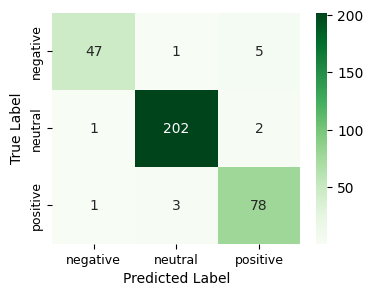

In [42]:
display(hp.summary_table.iloc[-1,:])
hp.EvaluateModel(model, test_tfds, y_test)

The result is also similar to that without using TensorFlow Dataset. The accuracy, precision, recall, f1-score on the test data are all above 0.9, and no more than 6 sentences in each class are misclassified.

# Additional: In-Context Learning
- Objective: to demonstrate Few Shot Learning

The following task is to identify which subject and which sentiment in a sentence. There are 7 training samples and 1 test sample, and 5 guess chance. The 'gpt2' is applied.

In [43]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')

In [58]:
exemplars = ["Nike has no plans to move all production to Southeast Asia.: Nike - neutral",
             "Componenta's net sales doubled: Componenta - positive",
             "Costco's operating margin came down to 2.4%: Costco - negative",
             "Amazon reports its profit increased: Amazon - positive",
             "Nokia shares go down to 13.21 euros: Nokia - negative",
             "Nordea Group's operating profit increased in 2010: Nordea - positive",
             "Uponor maintains its full-year guidance for 2010: Uponor - neutral",
]

In [59]:
acc = []
for k in range(7):
    sep = "\n"
    exemplar_string = sep.join(exemplars[0:k+1])
    few_shot_string =  exemplar_string + sep + "Tielinja increased net sales to $ 9.6 mn in 2005:"
    correct_ans = "Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive"

    shot_num = 5
    resp = generator(few_shot_string, max_length = 300, num_return_sequences=shot_num,
                    top_k=4, top_p=0.8,)

    correct_shot = 0
    for i, gen in enumerate(resp):
        print(gen['generated_text'].split('\n')[k+1])
        if gen['generated_text'].split('\n')[k+1] == correct_ans:
            correct_shot = correct_shot + 1

    acc.append(correct_shot/shot_num)
    print('Given {s1:d} samples, Accuracy score: {s2:.2f}'.format(s1=k+1, s2=acc[-1]))
    print('\n')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Nike - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Nike - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Nike - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja has been the largest brand in the world, and the brand has been the most successful in the world for a number of years. The brand is also one of the most successful in the world for a number of years. The company is one of the most successful in the world for a number of years.: Nike - neutral
Tielinja increased net sales to $ 9.6 mn in 2005: Nike -earned
Given 1 samples, Accuracy score: 0.00




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 2 samples, Accuracy score: 0.60




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 3 samples, Accuracy score: 0.60




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 4 samples, Accuracy score: 0.80




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 5 samples, Accuracy score: 0.60




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Nordea - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Nordea - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Nordea - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 6 samples, Accuracy score: 0.40


Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - negative
Tielinja increased net sales to $ 9.6 mn in 2005: Tielinja - positive
Given 7 samples, Accuracy score: 0.60




Text(0.5, 0, 'Number of Shots')

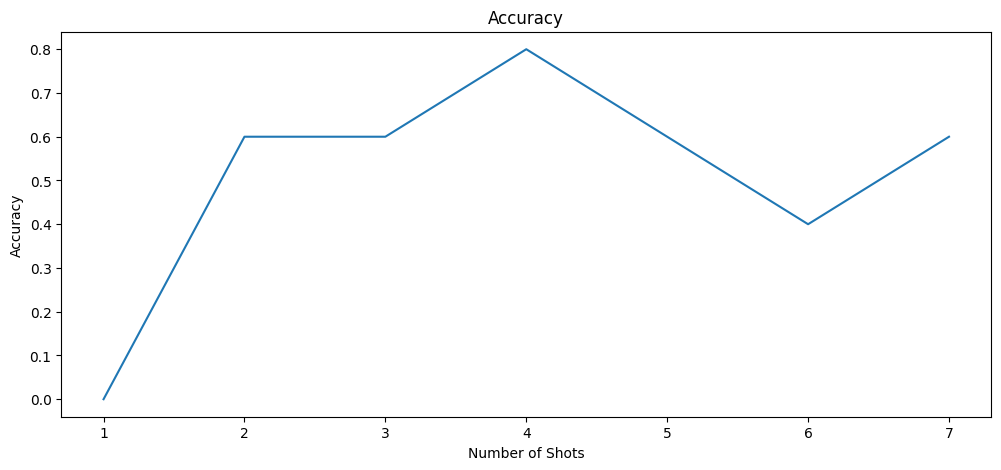

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(list(range(1,8)), acc)
ax.set_title('Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Shots')

It is surprising that only 2-4 training samples can make the model have 0.6-0.8 accuracy. However, the 5-7 training samples didn't make its performance even better. It's might because of the sample quality, and if given more data, such as 10-20 data the performance will probably be better and more stable.

In [61]:
print("Done")

Done
